# 머신 러닝 교과서 - 파이토치편

<table align="left"><tr><td>
<a href="https://colab.research.google.com/github/rickiepark/ml-with-pytorch/blob/main/ch07/ch07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="코랩에서 실행하기"/></a>
</td></tr></table>

## 패키지 버전 체크


check_packages.py 스크립트에서 로드하기 위해 폴더를 추가합니다:



In [1]:
import sys

# 코랩의 경우 깃허브 저장소로부터 python_environment_check.py를 다운로드 합니다.
if 'google.colab' in sys.modules:
    !wget https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/python_environment_check.py
else:
    sys.path.insert(0, '..')

In [2]:
import sys
sys.path.append('..')  # 상위 디렉토리 추가

from python_environment_check import check_packages

[OK] Your Python version is 3.11.12 (main, Apr  9 2025, 04:03:34) [MSC v.1943 64 bit (AMD64)]


권장 패키지 버전을 확인하세요:

In [3]:
from python_environment_check import check_packages


d = {
    'numpy': '1.21.2',
    'scipy': '1.7.0',
    'matplotlib': '3.4.3',
    'sklearn': '1.0',
    'pandas': '1.3.2',
    'xgboost': '1.5.0',
}
check_packages(d)

[OK] numpy 2.2.6
[OK] scipy 1.15.3
[OK] matplotlib 3.10.3
[OK] sklearn 1.6.1
[OK] pandas 2.2.3
[OK] xgboost 3.0.2


# 7장 - 다양한 모델을 결합한 앙상블 학습


### 목차

- 앙상블 학습
- 다수결 투표를 사용한 분류 앙상블
    - 간단한 다수결 투표 분류기 구현
    - 다수결 투표 방식을 사용하여 예측 만들기
    - 앙상블 분류기의 평가와 튜닝
- 배깅: 부트스트랩 샘플링을 통한 분류 앙상블
    - 배깅 알고리즘의 작동 방식
    - 배깅으로 Wine 데이터셋의 샘플 분류
- 약한 학습기를 이용한 에이다부스트
    - 부스팅 작동 원리
    - 사이킷런에서 에이다부스트 사용
- 그레이디언트 부스팅 – 손실 그레이디언트 기반의 앙상블 훈련
    - 에이다부스트와 그레이디언트 부스팅 비교
    - 그레이디언트 부스팅 알고리즘 소개
    - 분류를 위한 그레이디언트 부스팅 알고리즘
    - 그레이디언트 부스팅 분류 예제
    - XGBoost 사용하기
- 요약

In [4]:
from IPython.display import Image
%matplotlib inline

# 앙상블 학습


In [5]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch07/figures/07_01.png', width=500)

In [6]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch07/figures/07_02.png', width=500)

In [7]:
from scipy.special import comb
import math

def ensemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier / 2.))
    probs = [comb(n_classifier, k) * error**k * (1-error)**(n_classifier - k)
             for k in range(k_start, n_classifier + 1)]
    return sum(probs)

In [8]:
ensemble_error(n_classifier=11, error=0.25)

np.float64(0.03432750701904297)

In [9]:
import numpy as np


error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error)
              for error in error_range]

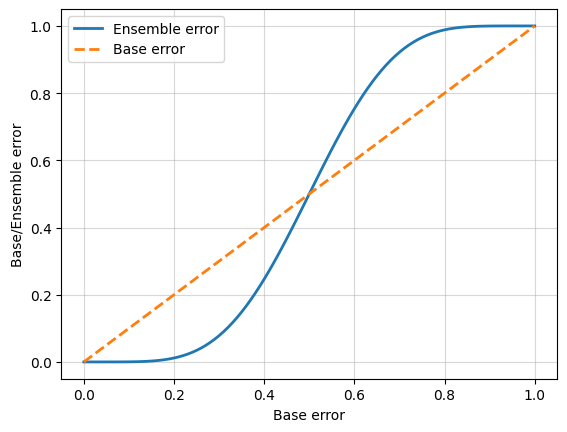

In [10]:
import matplotlib.pyplot as plt

plt.plot(error_range,
         ens_errors,
         label='Ensemble error',
         linewidth=2)

plt.plot(error_range,
         error_range,
         linestyle='--',
         label='Base error',
         linewidth=2)

plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
#plt.savefig('figures/07_03.png', dpi=300)
plt.show()

# 다수결 투표를 사용한 분류 앙상블


## 간단한 다수결 투표 분류기 구현


In [11]:
import numpy as np

np.argmax(np.bincount([0, 0, 1],
                      weights=[0.2, 0.2, 0.6]))

np.int64(1)

In [12]:
ex = np.array([[0.9, 0.1],
               [0.8, 0.2],
               [0.4, 0.6]])

p = np.average(ex,
               axis=0,
               weights=[0.2, 0.2, 0.6])
p

array([0.58, 0.42])

In [13]:
np.argmax(p)

np.int64(0)

In [14]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator


class MajorityVoteClassifier(BaseEstimator,
                             ClassifierMixin):
    """다수결 투표 앙상블 분류기

    매개변수
    ----------
    classifiers : 배열 타입, 크기 = [n_classifiers]
        앙상블에 사용할 분류기

    vote : str, {'classlabel', 'probability'}
        기본값: 'classlabel'
        'classlabel'이면 예측은 다수인 클래스 레이블의 인덱스가 됩니다
        'probability'면 확률 합이 가장 큰 인덱스로
        클래스 레이블을 예측합니다(보정된 분류기에 추천합니다)

    weights : 배열 타입, 크기 = [n_classifiers]
        선택 사항, 기본값: None
        'int' 또는 'float' 값의 리스트가 주어지면 분류기가 이 중요도로 가중치됩니다
        'weights=None'이면 동일하게 취급합니다

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """분류기를 학습합니다

        매개변수
        ----------
        X : {배열 타입, 희소 행렬},
            크기 = [n_samples, n_features]
            훈련 샘플 행렬

        y : 배열 타입, 크기 = [n_samples]
            타깃 클래스 레이블 벡터

        반환값
        -------
        self : 객체

        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote는 'probability' 또는 'classlabel'이어야 합니다"
                             "; (vote=%r)이 입력되었습니다."
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('분류기와 가중치 개수는 같아야 합니다'
                             '; 가중치 %d 개, 분류기 %d 개'
                             % (len(self.weights), len(self.classifiers)))

        # self.predict 메서드에서 np.argmax를 호출할 때
        # 클래스 레이블이 0부터 시작되어야 하므로 LabelEncoder를 사용합니다
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """X에 대한 클래스 레이블을 예측합니다

        매개변수
        ----------
        X : {배열 타입, 희소 행렬},
            크기 = [n_samples, n_features]
            샘플 데이터 행렬

        반환값
        ----------
        maj_vote : 배열 타입, 크기 = [n_samples]
            예측된 클래스 레이블

        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' 투표

            # clf.predict 메서드를 사용하여 결과를 모읍니다
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """X에 대한 클래스 확률을 예측합니다

        매개변수
        ----------
        X : {배열 타입, 희소 행렬},
            크기 = [n_samples, n_features]
            n_samples는 샘플의 개수고 n_features는 특성의 개수인
            샘플 데이터 행렬

        반환값
        ----------
        avg_proba : 배열 타입,
            크기 = [n_samples, n_classes]
            샘플마다 가중치가 적용된 클래스의 평균 확률

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """GridSearch를 위해 분류기의 매개변수 이름을 반환합니다"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out['%s__%s' % (name, key)] = value
            return out

## 다수결 투표 방식을 사용하여 예측 만들기


In [15]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test =\
       train_test_split(X, y,
                        test_size=0.5,
                        random_state=1,
                        stratify=y)

In [16]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

clf1 = LogisticRegression(penalty='l2',
                          C=0.001,
                          random_state=1)

clf2 = DecisionTreeClassifier(max_depth=1,
                              criterion='entropy',
                              random_state=0)

clf3 = KNeighborsClassifier(n_neighbors=1,
                            p=2,
                            metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])

clf_labels = ['Logistic regression', 'Decision tree', 'KNN']

print('10-겹 교차 검증:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='accuracy')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

10-겹 교차 검증:

ROC AUC: 0.44 (+/- 0.08) [Logistic regression]
ROC AUC: 0.86 (+/- 0.20) [Decision tree]
ROC AUC: 0.84 (+/- 0.15) [KNN]


In [17]:
# 다수결 (소프트) 투표
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3], vote='probability')

clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='accuracy')  # 또는 'accuracy'
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

ROC AUC: 0.44 (+/- 0.08) [Logistic regression]
ROC AUC: 0.86 (+/- 0.20) [Decision tree]
ROC AUC: 0.84 (+/- 0.15) [KNN]
ROC AUC: 0.86 (+/- 0.18) [Majority voting]


<역자 노트>

---

In [18]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import VotingClassifier

vc = VotingClassifier(estimators=[
    ('lr', pipe1), ('dt', clf2), ('knn', pipe3)], voting='soft')

scores = cross_validate(estimator=vc, X=X_train, y=y_train,
                        cv=10, scoring='accuracy')
print("ROC AUC: : %0.2f (+/- %0.2f) [%s]"
      % (scores['test_score'].mean(),
         scores['test_score'].std(), 'VotingClassifier'))

ROC AUC: : 0.86 (+/- 0.16) [VotingClassifier]


In [19]:
vc.set_params(verbose=True)

vc = vc.fit(X_train, y_train)

[Voting] ....................... (1 of 3) Processing lr, total=   0.0s
[Voting] ....................... (2 of 3) Processing dt, total=   0.0s
[Voting] ...................... (3 of 3) Processing knn, total=   0.0s


In [20]:
vc.predict_proba(X_test[:10])

array([[0.80858947, 0.19141053],
       [0.8079866 , 0.1920134 ],
       [0.80742132, 0.19257868],
       [0.81176643, 0.18823357],
       [0.81195787, 0.18804213],
       [0.17701335, 0.82298665],
       [0.17670558, 0.82329442],
       [0.17845724, 0.82154276],
       [0.1796253 , 0.8203747 ],
       [0.81076209, 0.18923791]])

---

## 앙상블 분류기의 평가와 튜닝


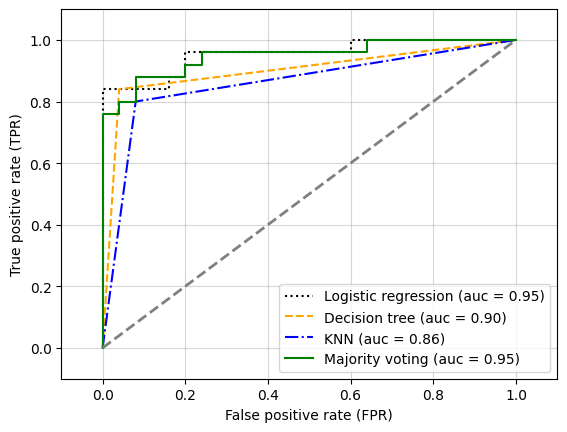

In [21]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls \
        in zip(all_clf,
               clf_labels, colors, linestyles):

    # 양성 클래스의 레이블이 1이라고 가정합니다
    y_pred = clf.fit(X_train,
                     y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                     y_score=y_pred)
    accuracy = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
             color=clr,
             linestyle=ls,
             label=f'{label} (auc = {accuracy:.2f})')

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')


#plt.savefig('figures/07_04', dpi=300)
plt.show()

In [22]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

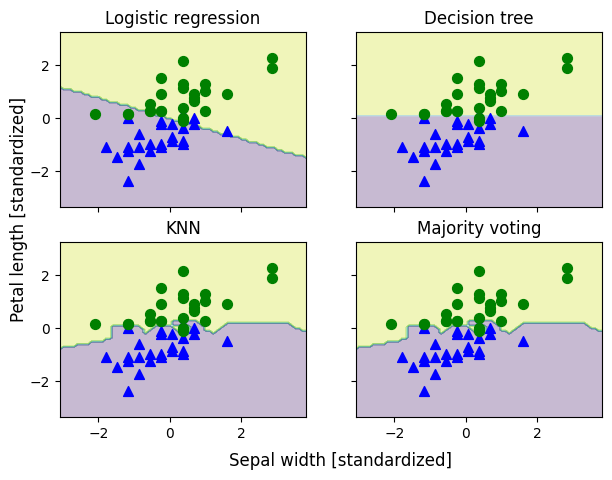

In [23]:
from itertools import product


all_clf = [pipe1, clf2, pipe3, mv_clf]

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=2, ncols=2,
                        sharex='col',
                        sharey='row',
                        figsize=(7, 5))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        all_clf, clf_labels):
    clf.fit(X_train_std, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)

    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0],
                                  X_train_std[y_train==0, 1],
                                  c='blue',
                                  marker='^',
                                  s=50)

    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0],
                                  X_train_std[y_train==1, 1],
                                  c='green',
                                  marker='o',
                                  s=50)

    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -5.,
         s='Sepal width [standardized]',
         ha='center', va='center', fontsize=12)
plt.text(-12.5, 4.5,
         s='Petal length [standardized]',
         ha='center', va='center',
         fontsize=12, rotation=90)

#plt.savefig('figures/07_05', dpi=300)
plt.show()

In [24]:
mv_clf.get_params()

{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]]),
 'pipeline-1__memory': None,
 'pipeline-1__steps': [('sc', StandardScaler()),
  ['clf', LogisticRegression(C=0.001, random_state=1)]],
 'pipeline-1__transform_input': None,
 'pipeline-1__verbose': False,
 'pipeline-1__sc': StandardScaler(),
 'pipeline-1__clf': LogisticRegression(C=0.001, random_state=1),
 'pipeline-1__sc__copy': True,
 'pipeline-1__sc__with_mean': True,
 'pipeline-1__sc__with_std': True,
 'pipeline-1__clf__C': 0.001,
 'pipeline-1__clf__class_weight': None,
 'pipeline-1__clf__dual': False,
 'pipeline-1__clf__fit_intercept': True,
 'pipeline-1__clf__intercept_scaling': 1,
 'pipeline-1__clf__l1_ratio': None,
 'pipeline-1__clf

In [25]:
from sklearn.model_selection import GridSearchCV


params = {'decisiontreeclassifier__max_depth': [1, 2],
          'pipeline-1__clf__C': [0.001, 0.1, 100.0]}

grid = GridSearchCV(estimator=mv_clf,
                    param_grid=params,
                    cv=10,
                    scoring='accuracy')
grid.fit(X_train, y_train)

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    mean_score = grid.cv_results_['mean_test_score'][r]
    std_dev = grid.cv_results_['std_test_score'][r]
    params = grid.cv_results_['params'][r]
    print(f'{mean_score:.3f} +/- {std_dev:.2f} {params}')

0.860 +/- 0.18 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.920 +/- 0.13 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.920 +/- 0.18 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.920 +/- 0.13 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.940 +/- 0.13 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.920 +/- 0.18 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


In [26]:
print(f'최적의 매개변수: {grid.best_params_}')
print(f'ROC AUC: {grid.best_score_:.2f}')

최적의 매개변수: {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
ROC AUC: 0.94


**노트**  
`GridSearchCV`의 `refit` 기본값은 `True`입니다(즉, `GridSeachCV(..., refit=True)`). 훈련된 `GridSearchCV` 추정기를 사용해 `predict` 메서드로 예측을 만들 수 있다는 뜻입니다. 예를 들면:

    grid = GridSearchCV(estimator=mv_clf,
                        param_grid=params,
                        cv=10,
                        scoring='accuracy')
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)

또한 `best_estimator_` 속성으로 "최상"의 추정기를 얻을 수 있습니다.

In [27]:
grid.best_estimator_.classifiers

[Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.1, random_state=1)]]),
 DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=0),
 Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]])]

In [28]:
mv_clf = grid.best_estimator_

In [29]:
mv_clf.set_params(**grid.best_estimator_.get_params())

MajorityVoteClassifier(classifiers=[Pipeline(steps=[('sc', StandardScaler()),
                                                    ('clf',
                                                     LogisticRegression(C=0.1,
                                                                        random_state=1))]),
                                    DecisionTreeClassifier(criterion='entropy',
                                                           max_depth=2,
                                                           random_state=0),
                                    Pipeline(steps=[('sc', StandardScaler()),
                                                    ('clf',
                                                     KNeighborsClassifier(n_neighbors=1))])],
                       vote='probability')

In [30]:
mv_clf

MajorityVoteClassifier(classifiers=[Pipeline(steps=[('sc', StandardScaler()),
                                                    ('clf',
                                                     LogisticRegression(C=0.1,
                                                                        random_state=1))]),
                                    DecisionTreeClassifier(criterion='entropy',
                                                           max_depth=2,
                                                           random_state=0),
                                    Pipeline(steps=[('sc', StandardScaler()),
                                                    ('clf',
                                                     KNeighborsClassifier(n_neighbors=1))])],
                       vote='probability')

<역자 노트>

---

In [31]:
from sklearn.ensemble import StackingClassifier

stack = StackingClassifier(estimators=[
    ('lr', pipe1), ('dt', clf2), ('knn', pipe3)],
                           final_estimator=LogisticRegression())

params = {'dt__max_depth': [1, 2],
          'lr__clf__C': [0.001, 0.1, 100.0]}

grid = GridSearchCV(estimator=stack,
                    param_grid=params,
                    cv=10,
                    scoring='accuracy')
grid.fit(X_train, y_train)

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_['mean_test_score'][r],
             grid.cv_results_['std_test_score'][r] / 2.0,
             grid.cv_results_['params'][r]))

0.840 +/- 0.10 {'dt__max_depth': 1, 'lr__clf__C': 0.001}
0.840 +/- 0.10 {'dt__max_depth': 1, 'lr__clf__C': 0.1}
0.860 +/- 0.12 {'dt__max_depth': 1, 'lr__clf__C': 100.0}
0.860 +/- 0.10 {'dt__max_depth': 2, 'lr__clf__C': 0.001}
0.880 +/- 0.10 {'dt__max_depth': 2, 'lr__clf__C': 0.1}
0.940 +/- 0.06 {'dt__max_depth': 2, 'lr__clf__C': 100.0}


In [32]:
print('최적의 매개변수: %s' % grid.best_params_)
print('정확도: %.2f' % grid.best_score_)

최적의 매개변수: {'dt__max_depth': 2, 'lr__clf__C': 100.0}
정확도: 0.94


---

# 배깅: 부트스트랩 샘플링을 통한 분류 앙상블


In [33]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch07/figures/07_06.png', width=500)

## 배깅 알고리즘의 작동 방식


In [34]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch07/figures/07_07.png', width=800)

## 배깅으로 Wine 데이터셋의 샘플 분류


In [35]:
# MacOS

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [36]:
import pandas as pd


df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

# UCI 머신 러닝 저장소에서 Wine 데이터셋을 다운로드할 수 없을 때
# 다음 주석을 해제하고 로컬 경로에서 데이터셋을 적재하세요:
# df_wine = pd.read_csv('wine.data', header=None)

# 클래스 1 제외
df_wine = df_wine[df_wine['Class label'] != 1]

y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values

In [37]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test =\
            train_test_split(X, y,
                             test_size=0.2,
                             random_state=1,
                             stratify=y)

In [38]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy',
                              max_depth=None,
                              random_state=1)

bag = BaggingClassifier(estimator=tree,
                        n_estimators=500,
                        max_samples=1.0,
                        max_features=1.0,
                        bootstrap=True,
                        bootstrap_features=False,
                        n_jobs=1,
                        random_state=1)

In [39]:
from sklearn.metrics import accuracy_score


tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print(f'결정 트리의 훈련 정확도/테스트 정확도 '
      f'{tree_train:.3f}/{tree_test:.3f}')

bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print(f'배깅의 훈련 정확도/테스트 정확도 '
      f'{bag_train:.3f}/{bag_test:.3f}')

결정 트리의 훈련 정확도/테스트 정확도 1.000/0.833
배깅의 훈련 정확도/테스트 정확도 1.000/0.917


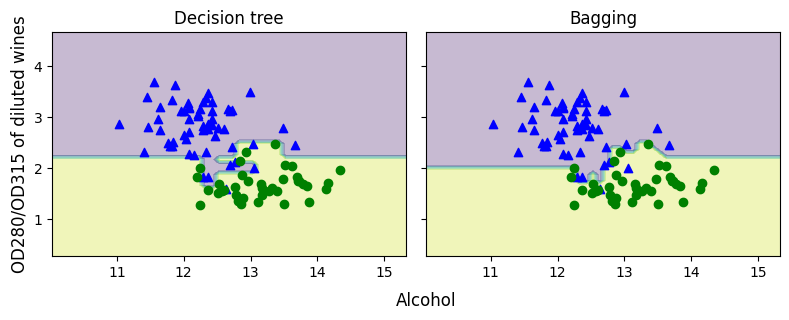

In [40]:
import numpy as np
import matplotlib.pyplot as plt


x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1, ncols=2,
                        sharex='col',
                        sharey='row',
                        figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, bag],
                        ['Decision tree', 'Bagging']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')

    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='green', marker='o')

    axarr[idx].set_title(tt)

axarr[0].set_ylabel('OD280/OD315 of diluted wines', fontsize=12)

plt.tight_layout()
plt.text(0, -0.2,
         s='Alcohol',
         ha='center',
         va='center',
         fontsize=12,
         transform=axarr[1].transAxes)

#plt.savefig('figures/07_08.png', dpi=300, bbox_inches='tight')
plt.show()

<역자 노트>

---

In [41]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(oob_score=True,
                            random_state=1)
rf.fit(X_train, y_train)

rf_train_score = rf.score(X_train, y_train)
rf_test_score = rf.score(X_test, y_test)
print('랜덤 포레스트의 훈련 정확도/테스트 정확도 %.3f/%.3f' %
      (rf_train_score, rf_test_score))
print('랜덤 포레스트의 OOB 정확도 %.3f' % rf.oob_score_)

랜덤 포레스트의 훈련 정확도/테스트 정확도 1.000/0.917
랜덤 포레스트의 OOB 정확도 0.884


In [42]:
bag = BaggingClassifier(estimator=tree,
                        n_estimators=500,
                        oob_score=True,
                        random_state=1)
bag.fit(X_train, y_train)

bag_train_score = bag.score(X_train, y_train)
bag_test_score = bag.score(X_test, y_test)
print('배깅의 훈련 정확도/테스트 정확도 %.3f/%.3f' %
      (bag_train_score, bag_test_score))
print('배깅의 OOB 정확도 %.3f' % bag.oob_score_)

배깅의 훈련 정확도/테스트 정확도 1.000/0.917
배깅의 OOB 정확도 0.895


---

# 약한 학습기를 이용한 에이다부스트


## 부스팅 작동 원리


In [43]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch07/figures/07_09.png', width=400)

In [44]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch07/figures/07_10.png', width=500)

In [45]:
y = np.array([1, 1, 1, -1, -1, -1,  1,  1,  1, -1])
yhat = np.array([1, 1, 1, -1, -1, -1, -1, -1, -1, -1])
correct = (y == yhat)
weights = np.full(10, 0.1)
print(weights)

epsilon = np.mean(~correct)
print(epsilon)

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
0.3


In [46]:
alpha_j = 0.5 * np.log((1-epsilon) / epsilon)
print(alpha_j)

0.42364893019360184


In [47]:
update_if_correct = 0.1 * np.exp(-alpha_j * 1 * 1)
print(update_if_correct)

0.06546536707079771


In [48]:
update_if_wrong_1 = 0.1 * np.exp(-alpha_j * 1 * -1)
print(update_if_wrong_1)

0.1527525231651947


In [49]:
update_if_wrong_2 = 0.1 * np.exp(-alpha_j * -1 * 1)
print(update_if_wrong_2)

0.1527525231651947


In [50]:
weights = np.where(correct == 1, update_if_correct, update_if_wrong_1)
print(weights)

[0.06546537 0.06546537 0.06546537 0.06546537 0.06546537 0.06546537
 0.15275252 0.15275252 0.15275252 0.06546537]


In [51]:
normalized_weights = weights / np.sum(weights)
print(normalized_weights)

[0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.16666667 0.16666667 0.16666667 0.07142857]


## 사이킷런에서 에이다부스트 사용


In [52]:
from sklearn.ensemble import AdaBoostClassifier


tree = DecisionTreeClassifier(criterion='entropy',
                              max_depth=1,
                              random_state=1)

ada = AdaBoostClassifier(estimator=tree,
                         n_estimators=500,
                         learning_rate=0.1,
                         random_state=1)

In [53]:
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print(f'결정 트리의 훈련 정확도/테스트 정확도 '
      f'{tree_train:.3f}/{tree_test:.3f}')

ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print(f'에이다부스트의 훈련 정확도/테스트 정확도 '
      f'{ada_train:.3f}/{ada_test:.3f}')

결정 트리의 훈련 정확도/테스트 정확도 0.916/0.875
에이다부스트의 훈련 정확도/테스트 정확도 0.968/0.917


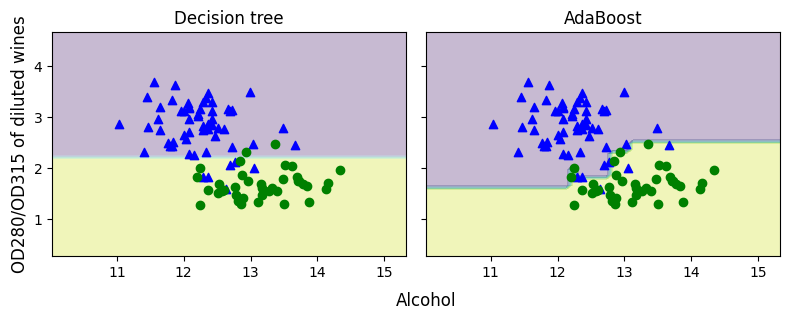

In [54]:
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, ada],
                        ['Decision tree', 'AdaBoost']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='green', marker='o')
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('OD280/OD315 of diluted wines', fontsize=12)

plt.tight_layout()
plt.text(0, -0.2,
         s='Alcohol',
         ha='center',
         va='center',
         fontsize=12,
         transform=axarr[1].transAxes)

# plt.savefig('figures/07_11.png', dpi=300, bbox_inches='tight')
plt.show()

# 그레이디언트 부스팅 – 손실 그레이디언트 기반의 앙상블 훈련


## 에이다부스트와 그레이디언트 부스팅 비교


## 그레이디언트 부스팅 알고리즘 소개


## 분류를 위한 그레이디언트 부스팅 알고리즘


## 그레이디언트 부스팅 분류 예제


In [55]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch07/figures/07_12.png', width=300)

In [56]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch07/figures/07_13.png', width=750)

In [57]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch07/figures/07_14.png', width=500)

In [58]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch07/figures/07_15.png', width=500)

In [59]:
Image(url='https://raw.githubusercontent.com/rickiepark/ml-with-pytorch/main/ch07/figures/07_16.png', width=800)

## XGBoost 사용하기


In [60]:
import xgboost as xgb

In [61]:
xgb.__version__

'3.0.2'

In [62]:
model = xgb.XGBClassifier(n_estimators=1000, learning_rate=0.01, max_depth=4, random_state=1, use_label_encoder=False)


gbm = model.fit(X_train, y_train)

y_train_pred = gbm.predict(X_train)
y_test_pred = gbm.predict(X_test)

gbm_train = accuracy_score(y_train, y_train_pred)
gbm_test = accuracy_score(y_test, y_test_pred)
print(f'XGboost 훈련 정확도/테스트 정확도 '
      f'{gbm_train:.3f}/{gbm_test:.3f}')

C:\Users\Admin\Desktop\lgu6_ml_dl\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:43:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGboost 훈련 정확도/테스트 정확도 0.968/0.917


<역자 노트>

---

In [63]:
from sklearn.ensemble import GradientBoostingClassifier

gbrt = GradientBoostingClassifier(n_estimators=20, random_state=42)
gbrt.fit(X_train, y_train)
gbrt_train = gbrt.score(X_train, y_train)
gbrt_test = gbrt.score(X_test, y_test)
print(f'GradientBoostingClassifier 훈련 정확도/테스트 정확도 '
      f'{gbrt_train:.3f}/{gbrt_test:.3f}')

GradientBoostingClassifier 훈련 정확도/테스트 정확도 1.000/0.917


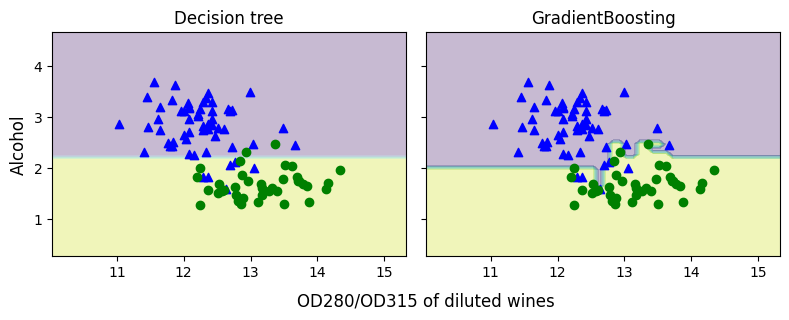

In [64]:
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, gbrt],
                        ['Decision tree', 'GradientBoosting']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='green', marker='o')
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)

plt.tight_layout()
plt.text(0, -0.2,
         s='OD280/OD315 of diluted wines',
         ha='center', va='center', fontsize=12,
         transform=axarr[1].transAxes)
plt.show()

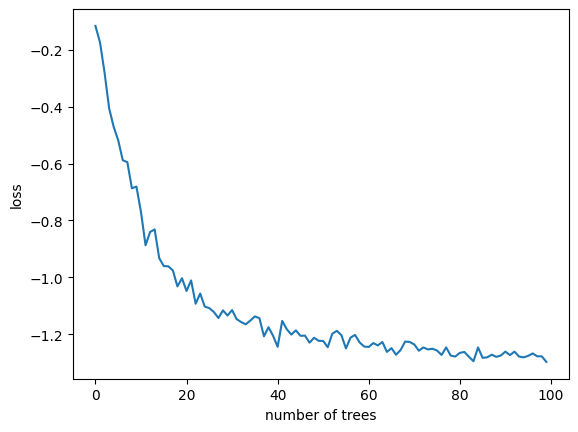

In [65]:
gbrt = GradientBoostingClassifier(n_estimators=100,
                                  subsample=0.5,
                                  random_state=1)
gbrt.fit(X_train, y_train)
oob_loss = np.cumsum(-gbrt.oob_improvement_)
plt.plot(range(100), oob_loss)
plt.xlabel('number of trees')
plt.ylabel('loss')
plt.show()

In [66]:
from sklearn.ensemble import HistGradientBoostingClassifier

hgbc = HistGradientBoostingClassifier(random_state=1)
hgbc.fit(X_train, y_train)

hgbc_train = gbrt.score(X_train, y_train)
hgbc_test = gbrt.score(X_test, y_test)
print(f'HistGradientBoostingClassifier 훈련 정확도/테스트 정확도 '
      f'{hgbc_train:.3f}/{hgbc_test:.3f}')

HistGradientBoostingClassifier 훈련 정확도/테스트 정확도 1.000/0.917


In [67]:
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(verbose=-1, random_state=1)
lgb.fit(X_train, y_train)

lgb_train = lgb.score(X_train, y_train)
lgb_test = lgb.score(X_test, y_test)

print(f'LightGBM 훈련 정확도/테스트 정확도 '
      f'{lgb_train:.3f}/{lgb_test:.3f}')

LightGBM 훈련 정확도/테스트 정확도 0.979/0.917


C:\Users\Admin\Desktop\lgu6_ml_dl\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\Admin\Desktop\lgu6_ml_dl\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


---

# 요약